In [30]:
import os
import numpy as np
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from pathlib import Path
from echoes import ESNRegressor
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.model_selection import ParameterGrid

In [2]:
def preprocess_connectivity_matrix(connectivity_matrix):
    # set zero diagonal
    np.fill_diagonal(connectivity_matrix, 0)

    # remove inf and nan
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0

    # remove negatives 
    connectivity_matrix[connectivity_matrix < 0] = 0
    
    # make sure weights are float
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [3]:
def shift_array(arr, n):
    # Shift the array by n positions
    shifted_arr = np.roll(arr, n)
    shifted_arr[:n] = 0

    return shifted_arr

def generate_data(time_steps):
    return np.random.uniform(-0.5, 0.5, time_steps)

def compute_memory_capacity(esn, train_data, test_data, max_lag):
    # Compute memory capacity for each lag
    total_memory_capacity = 0
    correlations = np.zeros(max_lag)
    for lag in range(1, max_lag + 1):
        X_train = train_data.reshape(-1, 1)
        y_train = shift_array(train_data, lag)
        X_test = test_data.reshape(-1, 1)
        y_test = shift_array(test_data, lag)
    
        # Train the ESN
        esn.fit(X_train, y_train)

        # Predict using the trained ESN
        predicted = esn.predict(X_test)
        # Calculate the squared correlation coefficient
        correlation, _ = pearsonr(predicted.flatten(), y_test)
        correlations[lag-1] = correlation
        total_memory_capacity += correlation ** 2
    return correlations, total_memory_capacity

In [4]:
max_lag = 70
param_grid = {
    'n_transient': [50, 100, 150],
    'spectral_radius': [0.8, 0.9, 1.0],
    'input_scaling': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'leak_rate': [0.6, 0.8, 1],
    'bias': [0],
    'random_state': [42]
}
# Generate random data
data = generate_data(5000)

# Split data into training and testing sets
train_data = data[4000:]
test_data = data[:1000]
grid = ParameterGrid(param_grid)

best_score = float('-inf')  
best_params = None

for params in grid:
    esn = ESNRegressor(**params)
    _, total_memory_capacity = compute_memory_capacity(esn, train_data, test_data, max_lag)
    
    if total_memory_capacity > best_score:  
        best_score = total_memory_capacity
        best_params = params

KeyboardInterrupt: 

In [41]:
def get_avg_memory_capacities(directory, data, max_lag, W_in, max_num_files=None):
    train_data = data[4000:]
    test_data = data[:1000]
    files = os.listdir(directory)
    
    if max_num_files is None:
        max_num_files = len(files)
    
    memory_capacities = np.zeros(max_num_files)
    for (i, file) in enumerate(files):
        if i > max_num_files:
            return memory_capacities
        if file.endswith(".pkl"):
            filepath = os.path.join(directory, file)
            subject = file[:-4]
            # Open the pickle file and load the matrix
            with open(filepath, 'rb') as pickle_file:
                
                matrix = pickle.load(pickle_file)
                connectivity_matrix = preprocess_connectivity_matrix(matrix.to_numpy())
               
                # Reservoir follows the connectivity matrix of a person with ADHD
                esn = ESNRegressor(n_transient=50,
                           input_scaling=1e-8,
                           spectral_radius=0.9,
                           leak_rate=1,
                           bias=0,
                           W_in=W_in,
                           W=connectivity_matrix)
                
                _, total_memory_capacity = compute_memory_capacity(esn, train_data, test_data, max_lag)
                memory_capacities[i] = total_memory_capacity
    return memory_capacities

In [52]:
def plot_violin_with_box_and_mean(types_name, types_data, plot_title, x_label, y_label):
    # Create a DataFrame for easier plotting with Seaborn
    data = []
    for name, d in zip(types_name, types_data):
        data.extend([(name, value) for value in d])
    sns.set(style="darkgrid")
    df = pd.DataFrame(data, columns=['Species', 'Value'])
    
    # Plotting with Seaborn
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Species', y='Value', data=df, palette="pastel", hue='Species', inner="box")
    
    # Calculate means and plot them
    means = df.groupby('Species')['Value'].mean().values
    for i, mean in enumerate(means):
        plt.text(i, mean, f'mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=12)
    
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Show plot
    plt.show()


In [43]:
max_lag = 70
# Generate random data
data = generate_data(5000)
W_in = np.random.uniform(low=-1, high=1, size=(112, 1))

directory_adhd = Path("datasets/HO_datasets_all/ADHD/")
memory_capacities_adhd = get_avg_memory_capacities(directory_adhd, data, max_lag, W_in) 

In [44]:
directory_control = Path("datasets/HO_datasets_all/Control/")
memory_capacities_control = get_avg_memory_capacities(directory_control, data, max_lag, W_in) 

In [45]:
np.save('mem_cap_adhd.npy', memory_capacities_adhd)
np.save('mem_cap_control.npy', memory_capacities_control)

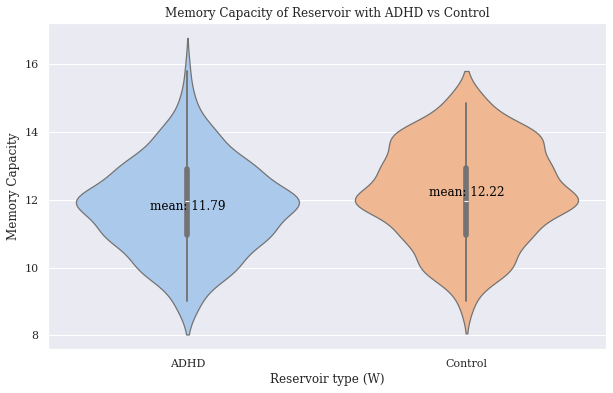

In [53]:
data = [memory_capacities_adhd, memory_capacities_control]
title = 'Memory Capacity of Reservoir with ADHD vs Control'
x_label = 'Reservoir type (W)'
y_label = 'Memory Capacity'
plot_violin_with_box_and_mean(['ADHD', 'Control'], data, title, x_label, y_label)

In [47]:
# Two-tailed t-test for independent samples
t_statistic_g, p_value_g = ttest_ind(memory_capacities_adhd, memory_capacities_control)

print("")
print("T-statistic for connectomes:", t_statistic_g)
print("P-value for connectomes:", p_value_g)


T-statistic for connectomes: -2.9456243158508557
P-value for connectomes: 0.0034247127788623014
